In [1]:
import pandas as pd

# Load dataset
df = pd.read_csv("cleaned_wait_times.csv")

# Pivot the dataset to convert metrics to columns
pivot_df = df.pivot_table(
    index=["Province", "Region", "Indicator", "Data year"],
    columns="Metric",
    values="Indicator result"
).reset_index()
pivot_df.columns.name = None  # Remove column index name

# Sort for consistent lag feature generation
pivot_df = pivot_df.sort_values(by=["Province", "Region", "Indicator", "Data year"])

# Create lag features
pivot_df["Volume_lag1"] = pivot_df.groupby(["Province", "Region", "Indicator"])["Volume"].shift(1)
pivot_df["% Benchmark_lag1"] = pivot_df.groupby(["Province", "Region", "Indicator"])["% Meeting Benchmark"].shift(1)

# Create a time trend feature
pivot_df["Years Since Start"] = pivot_df["Data year"] - pivot_df["Data year"].min()
pivot_df.head()

,Province,Region,Indicator,Data year,% Meeting Benchmark,50th Percentile,90th Percentile,Volume,Volume_lag1,% Benchmark_lag1,Years Since Start
0,Alberta,Calgary Zone,Bladder Cancer Surgery,2008,NaN,25.0,60.0,254.0,NaN,NaN,0
1,Alberta,Calgary Zone,Bladder Cancer Surgery,2009,NaN,25.0,60.0,254.0,254.0,NaN,1
2,Alberta,Calgary Zone,Bladder Cancer Surgery,2010,NaN,25.0,60.0,254.0,254.0,NaN,2
3,Alberta,Calgary Zone,Bladder Cancer Surgery,2011,NaN,25.0,60.0,254.0,254.0,NaN,3
4,Alberta,Calgary Zone,Bladder Cancer Surgery,2012,NaN,25.0,60.0,254.0,254.0,NaN,4


In [2]:
# Separate dataset for Volume 
volume_df = pivot_df.dropna(subset=["Volume", "Volume_lag1", "% Benchmark_lag1", "Years Since Start"]).copy()
volume_df.head()

,Province,Region,Indicator,Data year,% Meeting Benchmark,50th Percentile,90th Percentile,Volume,Volume_lag1,% Benchmark_lag1,Years Since Start
33,Alberta,Calgary Zone,CABG,2009,93.0,17.0,156.0,665.0,208.0,99.0,1
34,Alberta,Calgary Zone,CABG,2010,95.0,15.0,133.0,590.0,665.0,93.0,2
35,Alberta,Calgary Zone,CABG,2011,95.0,15.0,134.0,369.0,590.0,95.0,3
36,Alberta,Calgary Zone,CABG,2012,NaN,11.0,84.0,466.0,369.0,95.0,4
65,Alberta,Calgary Zone,Cataract surgery,2009,61.0,88.0,270.0,548.0,548.0,71.0,1


In [3]:
# Separate dataset for Benchmark %
benchmark_df = pivot_df.dropna(subset=["% Meeting Benchmark", "Volume", "Volume_lag1", "% Benchmark_lag1", "Years Since Start"]).copy()
benchmark_df.head()

,Province,Region,Indicator,Data year,% Meeting Benchmark,50th Percentile,90th Percentile,Volume,Volume_lag1,% Benchmark_lag1,Years Since Start
33,Alberta,Calgary Zone,CABG,2009,93.0,17.0,156.0,665.0,208.0,99.0,1
34,Alberta,Calgary Zone,CABG,2010,95.0,15.0,133.0,590.0,665.0,93.0,2
35,Alberta,Calgary Zone,CABG,2011,95.0,15.0,134.0,369.0,590.0,95.0,3
65,Alberta,Calgary Zone,Cataract surgery,2009,61.0,88.0,270.0,548.0,548.0,71.0,1
66,Alberta,Calgary Zone,Cataract surgery,2010,48.0,118.0,331.0,548.0,548.0,61.0,2


In [4]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Define features and target
volumn_features = ["Province", "Region", "Indicator", "Volume_lag1", "% Benchmark_lag1", "Years Since Start"]
X_volumn = volume_df[volumn_features]
y_volumn = volume_df["Volume"]

# One-hot encode categorical features
v_preprocessor = ColumnTransformer(
    transformers=[("category_for_volumn", OneHotEncoder(handle_unknown="ignore"), ["Province", "Region", "Indicator"])],
    remainder="passthrough"  
)

v_model_pipeline = make_pipeline(v_preprocessor, RandomForestRegressor(random_state=42))
X_train, X_test, y_train, y_test = train_test_split(X_volumn, y_volumn, test_size=0.2, random_state=42)
v_model_pipeline.fit(X_train, y_train)

y_pred = v_model_pipeline.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Predict on full dataset
volume_df["Predicted Volume"] = v_model_pipeline.predict(X_volumn)

print(f"Volume Model: MAE: {mae:.2f} | RMSE: {rmse:.2f}")


Volume Model: MAE: 52.44 | RMSE: 105.06


In [5]:
# Define features and target
benchmark_features = ["Province", "Region", "Indicator", "Volume", "Volume_lag1", "% Benchmark_lag1", "Years Since Start"]
X_benchmark = benchmark_df[benchmark_features]
y_benchmark = benchmark_df["% Meeting Benchmark"]

# One-hot encode categorical features
b_preprocessor = ColumnTransformer(
    transformers=[("category_for_benchmark", OneHotEncoder(handle_unknown="ignore"), ["Province", "Region", "Indicator"])],
    remainder="passthrough"
)

# Build model pipeline
b_model_pipeline = make_pipeline(b_preprocessor, RandomForestRegressor(random_state=42))

# Split data
Xb_train, Xb_test, yb_train, yb_test = train_test_split(X_benchmark, y_benchmark, test_size=0.2, random_state=42)

# Train model
b_model_pipeline.fit(Xb_train, yb_train)

# Predict and evaluate
yb_pred = b_model_pipeline.predict(Xb_test)
benchmark_mae = mean_absolute_error(yb_test, yb_pred)
benchmark_rmse = np.sqrt(mean_squared_error(yb_test, yb_pred))

# Predict full dataset
benchmark_df["Predicted % Benchmark"] = b_model_pipeline.predict(X_benchmark)

# Evaluation Output
print(f"Benchmark % Model: MAE: {benchmark_mae:.2f}% | RMSE: {benchmark_rmse:.2f}%")


Benchmark % Model: MAE: 6.92% | RMSE: 10.35%


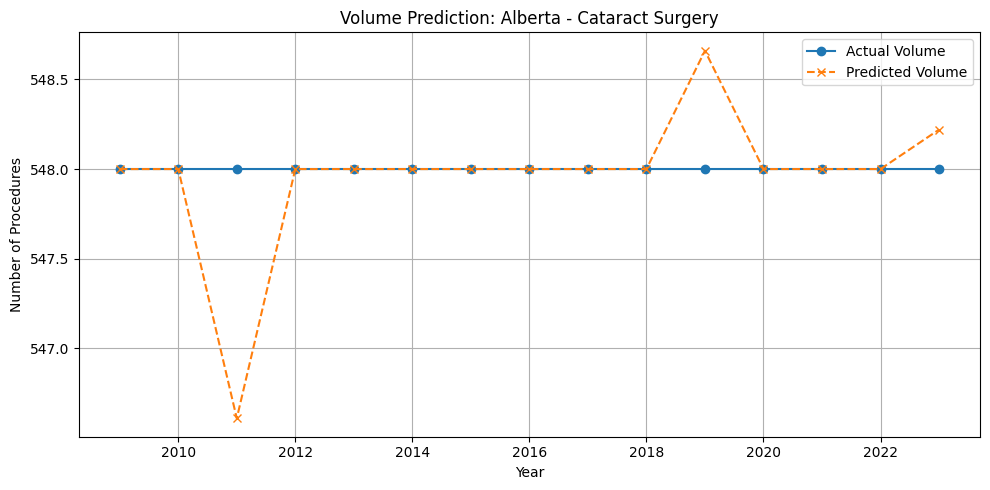

In [6]:
import matplotlib.pyplot as plt

# Visualize Volume prediction for Alberta - Cataract Surgery
sample_volume = volume_df[(volume_df["Province"] == "Alberta") & (volume_df["Indicator"] == "Cataract surgery")]
plt.figure(figsize=(10, 5))
plt.plot(sample_volume["Data year"], sample_volume["Volume"], marker='o', label="Actual Volume")
plt.plot(sample_volume["Data year"], sample_volume["Predicted Volume"], marker='x', linestyle='--', label="Predicted Volume")
plt.title("Volume Prediction: Alberta - Cataract Surgery")
plt.xlabel("Year")
plt.ylabel("Number of Procedures")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

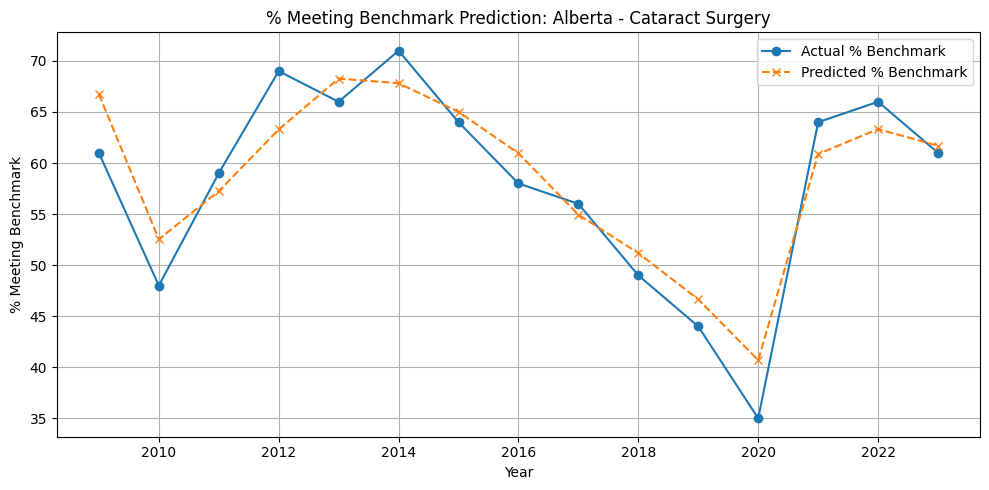

In [7]:
# Visualize Benchmark % prediction for Alberta - Cataract Surgery
sample_benchmark = benchmark_df[(benchmark_df["Province"] == "Alberta") & (benchmark_df["Indicator"] == "Cataract surgery")]
plt.figure(figsize=(10, 5))
plt.plot(sample_benchmark["Data year"], sample_benchmark["% Meeting Benchmark"], marker='o', label="Actual % Benchmark")
plt.plot(sample_benchmark["Data year"], sample_benchmark["Predicted % Benchmark"], marker='x', linestyle='--', label="Predicted % Benchmark")
plt.title("% Meeting Benchmark Prediction: Alberta - Cataract Surgery")
plt.xlabel("Year")
plt.ylabel("% Meeting Benchmark")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [8]:
# Calculate financial risk
# benchmark_df["Predicted Volume"] = volume_model.predict(benchmark_df[["Volume_lag1", "% Benchmark_lag1", "Years Since Start"]])
benchmark_df["Predicted Volume"] = v_model_pipeline.predict(
    benchmark_df[["Province", "Region", "Indicator", "Volume_lag1", "% Benchmark_lag1", "Years Since Start"]]
)
PENALTY_COST_PER_CASE = 2000
benchmark_df["Financial Risk"] = (
    (1 - benchmark_df["Predicted % Benchmark"] / 100) *
    benchmark_df["Predicted Volume"] *
    PENALTY_COST_PER_CASE
)
benchmark_df.head()

,Province,Region,Indicator,Data year,% Meeting Benchmark,50th Percentile,90th Percentile,Volume,Volume_lag1,% Benchmark_lag1,Years Since Start,Predicted % Benchmark,Predicted Volume,Financial Risk
33,Alberta,Calgary Zone,CABG,2009,93.0,17.0,156.0,665.0,208.0,99.0,1,95.260,510.270,48373.596
34,Alberta,Calgary Zone,CABG,2010,95.0,15.0,133.0,590.0,665.0,93.0,2,93.860,583.125,71607.750
35,Alberta,Calgary Zone,CABG,2011,95.0,15.0,134.0,369.0,590.0,95.0,3,95.625,463.430,40550.125
65,Alberta,Calgary Zone,Cataract surgery,2009,61.0,88.0,270.0,548.0,548.0,71.0,1,66.745,548.000,364474.800
66,Alberta,Calgary Zone,Cataract surgery,2010,48.0,118.0,331.0,548.0,548.0,61.0,2,52.535,548.000,520216.400


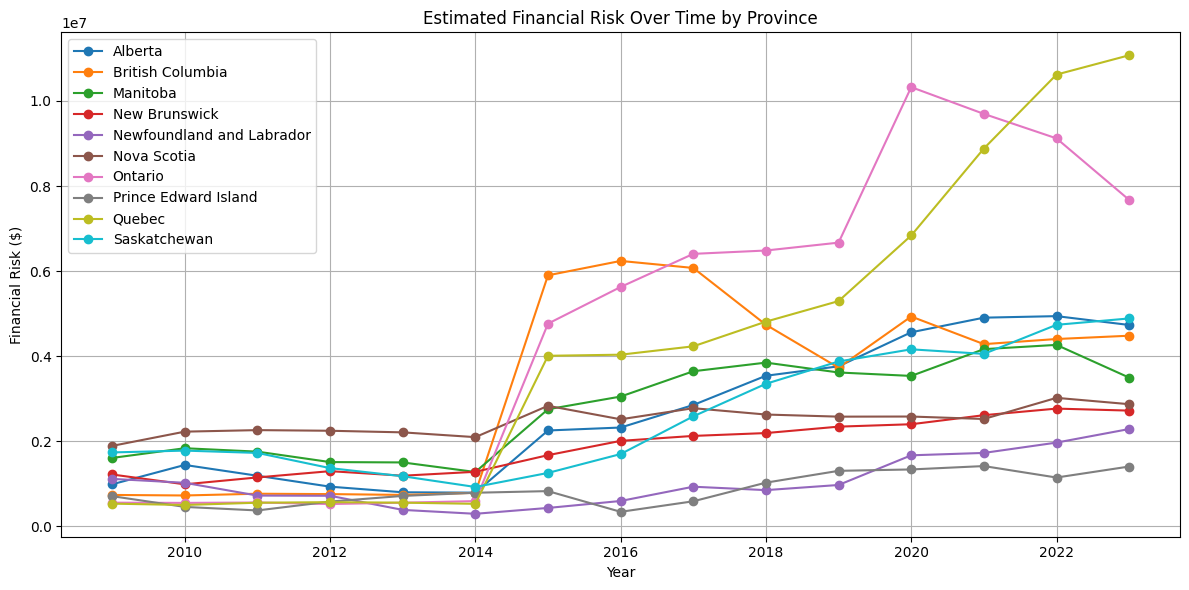

In [9]:
# Visualize Estimated Financial Risk Over Time by Province
risk_summary = benchmark_df.groupby(["Province", "Data year"])["Financial Risk"].sum().reset_index()
plt.figure(figsize=(12, 6))
for province in risk_summary["Province"].unique():
    province_data = risk_summary[risk_summary["Province"] == province]
    plt.plot(province_data["Data year"], province_data["Financial Risk"], marker='o', label=province)

plt.title("Estimated Financial Risk Over Time by Province")
plt.xlabel("Year")
plt.ylabel("Financial Risk ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

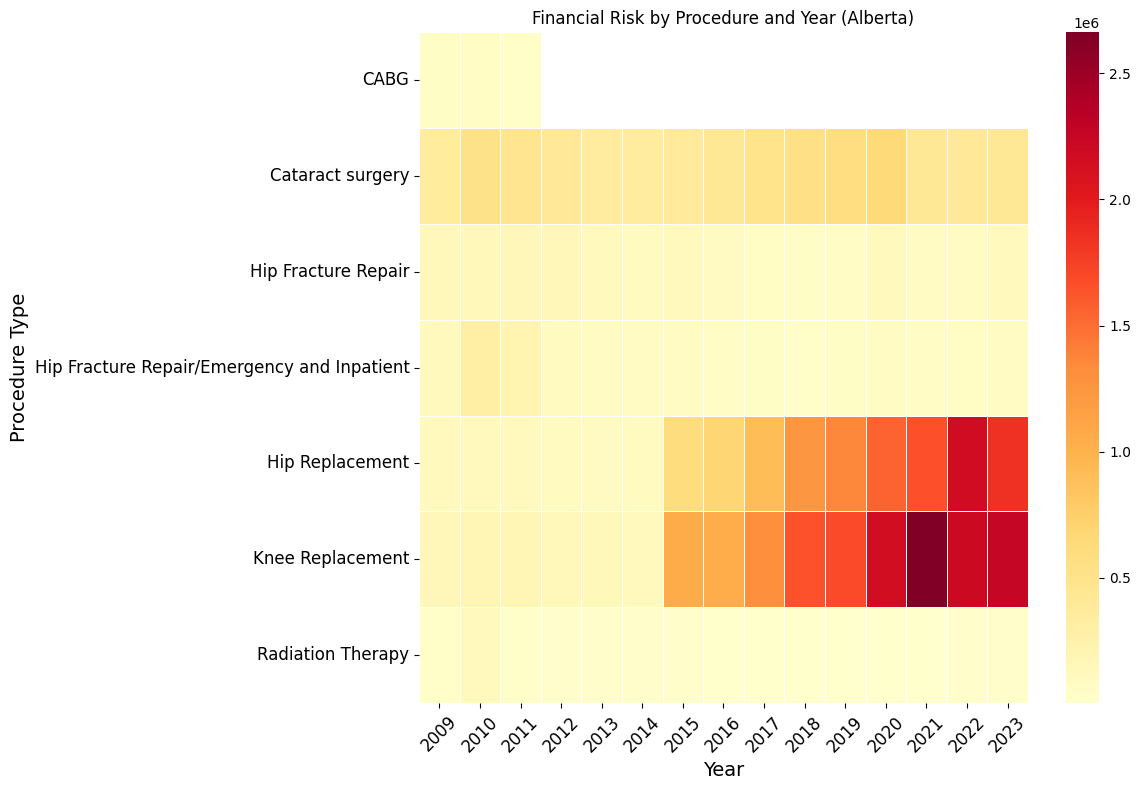

In [17]:
import seaborn as sns

# Group financial risk by Province, Year, and Procedure
procedure_risk = benchmark_df.groupby(["Province", "Data year", "Indicator"])["Financial Risk"].sum().reset_index()

# Filter for Alberta
alberta_procedures = procedure_risk[procedure_risk["Province"] == "Alberta"]

# Pivot for heatmap format
pivot_alberta = alberta_procedures.pivot(index="Indicator", columns="Data year", values="Financial Risk")

# Plot heatmap
plt.figure(figsize=(12, 8))
plt.xticks(ticks=np.arange(len(pivot_alberta.columns)), labels=pivot_alberta.columns, rotation=45, fontsize=12)
plt.yticks(ticks=np.arange(len(pivot_alberta.index)), labels=pivot_alberta.index, fontsize=12)
sns.heatmap(pivot_alberta, annot=False, fmt=".0f", cmap="YlOrRd", linewidths=.5)
plt.title("Financial Risk by Procedure and Year (Alberta)")
plt.xlabel("Year", fontsize =14)
plt.ylabel("Procedure Type", fontsize = 14)
plt.tight_layout()
plt.show()